# Import

In [1]:
from gsw.conversions import CT_from_pt, SA_from_SP, p_from_z
from gsw.density import sound_speed
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pyinterp
import pyinterp.fill
import pyinterp.backends.xarray
from collections import namedtuple

from datetime import datetime
import cartopy.crs as ccrs

ModuleNotFoundError: No module named 'gsw'

In [27]:
s = xr.open_dataset('/DATASET/eNATL/eNATL60_BLB002_degraded_vosaline.nc') #loading temp data
t = xr.open_dataset('/DATASET/eNATL/eNATL60_BLB002_degraded_votemper.nc') #loading salinity data
c = xr.open_dataset('/DATASET/eNATL/eNATL60_BLB002_sound_speed_0_1000m_regrid.nc') #loading celerity data  
##! Consider the regrid issue, outliers incorporation

<xarray.Dataset>
Dimensions:            (y: 308, x: 245, z: 107, time_counter: 365)
Coordinates:
    nav_lon            (y, x) float32 ...
    nav_lat            (y, x) float32 ...
  * z                  (z) float64 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * time_counter       (time_counter) datetime64[ns] 2009-07-01T12:00:00 ... ...
Dimensions without coordinates: y, x
Data variables:
    degraded_vosaline  (time_counter, z, y, x) float32 ...
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

In [12]:
t

<xarray.Dataset>
Dimensions:            (y: 308, x: 245, z: 107, time_counter: 365)
Coordinates:
    nav_lon            (y, x) float32 ...
    nav_lat            (y, x) float32 ...
  * z                  (z) float64 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * time_counter       (time_counter) datetime64[ns] 2009-07-01T12:00:00 ... ...
Dimensions without coordinates: y, x
Data variables:
    degraded_votemper  (time_counter, z, y, x) float32 ...
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

In [28]:
c

<xarray.Dataset>
Dimensions:   (lon: 240, lat: 240, z: 107, time: 365)
Coordinates:
  * lon       (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat       (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z         (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time      (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00
Data variables:
    celerity  (time, z, lat, lon) float64 ...

# Maps

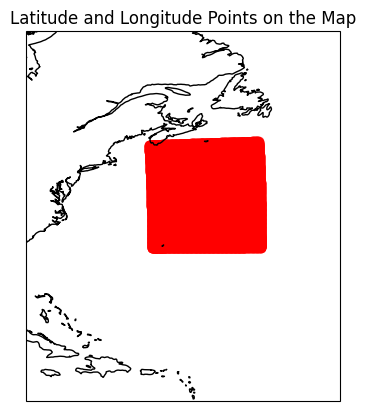

In [13]:
# Create a Cartopy projection (e.g., PlateCarree for lat/lon)
projection = ccrs.PlateCarree()

# Create a map using Cartopy
ax = plt.axes(projection = ccrs.PlateCarree())
#ax.stock_img()  ###view all earth
ax.set_extent([-80, -45, 15, 55])

for i in range(245):
    lat = t.nav_lat.values[:,i]
    lon = t.nav_lon.values[:,i]

    # Plot points on the map
    plt.scatter(lon, lat, color='red', marker='o', transform=projection, alpha= 0.5)

# Add map features (e.g., coastlines, country borders, etc.)
ax.coastlines()

# Set the title
plt.title('Latitude and Longitude Points on the Map')

# Show the plot
plt.show()


#! What is the CRS ?

# Variables

In [14]:
i_time = 0
i_lat = 0
i_lon = 0

## Depth

Text(0.5, 0, 'points')

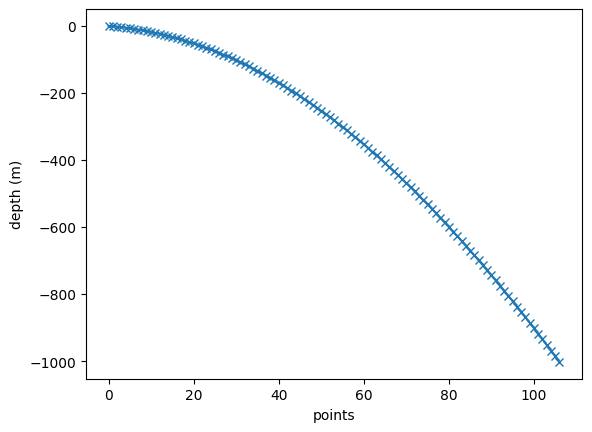

In [15]:
plt.plot(-t.z.values, '-x')  ##t.z is defined postive down, hence the '-'
plt.ylabel("depth (m)")
plt.xlabel("points")

## Practical Salinity

Text(0.5, 1.0, 'Practical salinity per depth at (-65.97, 32.02) for t=2009-07-01T12')

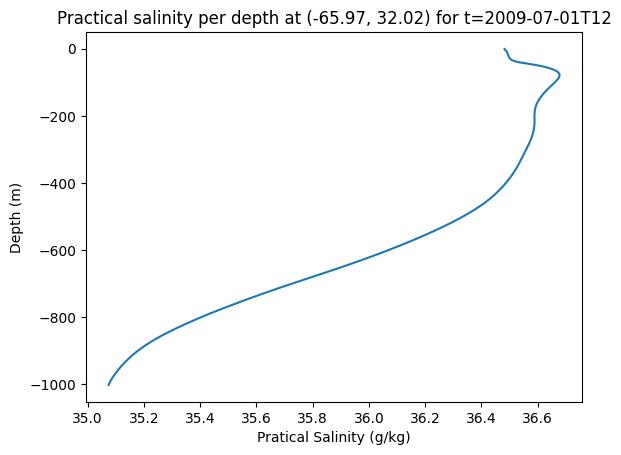

In [16]:
prac_sal = s.degraded_vosaline.values[i_time,:,i_lon,i_lat]

plt.plot(prac_sal,-s.z)
plt.ylabel("Depth (m)")
plt.xlabel("Pratical Salinity (g/kg)")
plt.title(f"Practical salinity per depth at ({s.nav_lon.values[0,i_lat]:.2f}, {s.nav_lat.values[0,i_lat]:.2f}) for t={s.time_counter.values[i_time].astype('datetime64[h]')}")

## Potential Temperature

Text(0.5, 1.0, 'Potential temperature per depth at (-65.97, 32.02) for t=2009-07-01T12')

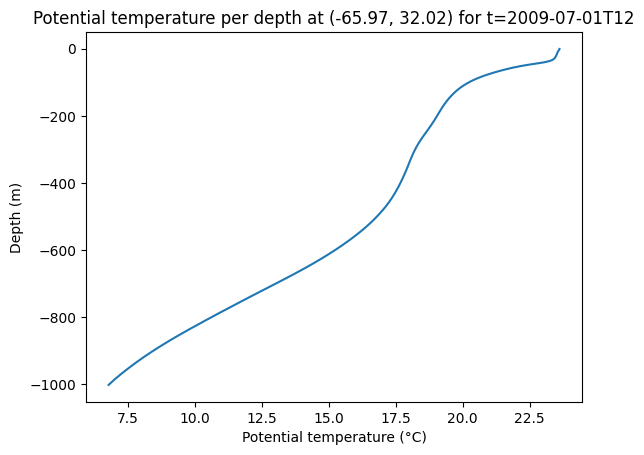

In [17]:
temp = t.degraded_votemper.values[i_time,:,i_lon,i_lat]

plt.plot(temp,-t.z)
plt.ylabel("Depth (m)")
plt.xlabel("Potential temperature (°C)")
plt.title(f"Potential temperature per depth at ({t.nav_lon.values[0,i_lat]:.2f}, {t.nav_lat.values[0,i_lat]:.2f}) for t={t.time_counter.values[i_time].astype('datetime64[h]')}")

## Pressure

Text(0.5, 1.0, 'Pressure per depth at (-65.97, 32.02)')

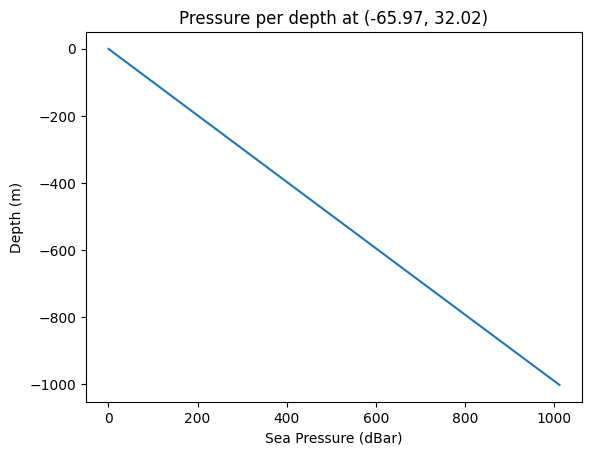

In [18]:
pressure = p_from_z(-t.z, t.nav_lat) # calculating the pressure at vertical levels

plt.plot(pressure.values[:,i_lon,i_lat], -t.z)
plt.ylabel('Depth (m)')
plt.xlabel('Sea Pressure (dBar)')
plt.title(f"Pressure per depth at ({t.nav_lon.values[0,i_lat]:.2f}, {t.nav_lat.values[0,i_lat]:.2f})")
        

## Absolute salinity

In [19]:
SA_array = SA_from_SP(s.degraded_vosaline, pressure, s.nav_lon, s.nav_lat) # calculating absolute salinity from practical salinity

Text(0.5, 1.0, 'Practical salinity per depth at (-65.97, 32.02) for t=2009-07-01T12')

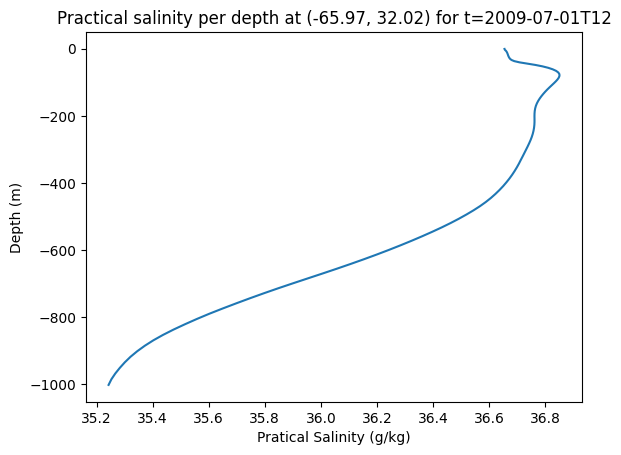

In [20]:
abs_sal = SA_array[i_time,:,i_lat,i_lon]

plt.plot(abs_sal,-s.z)
plt.ylabel("Depth (m)")
plt.xlabel("Pratical Salinity (g/kg)")
plt.title(f"Practical salinity per depth at ({s.nav_lon.values[0,i_lat]:.2f}, {s.nav_lat.values[0,i_lat]:.2f}) for t={s.time_counter.values[i_time].astype('datetime64[h]')}")

## Conservative temperature

In [21]:
CT_array = CT_from_pt(SA_array, t.degraded_votemper) # calculating the conservative temperature from potential temperature

Text(0.5, 1.0, 'Conservative temperature per depth at (-65.97, 32.02) for t=2009-07-01T12')

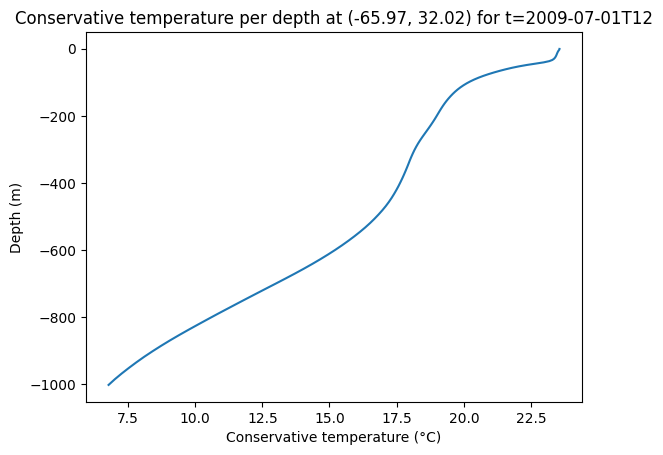

In [22]:
cons_temp = CT_array[i_time,:,i_lat,i_lon]

plt.plot(cons_temp,-t.z)
plt.ylabel("Depth (m)")
plt.xlabel("Conservative temperature (°C)")
plt.title(f"Conservative temperature per depth at ({s.nav_lon.values[0,i_lat]:.2f}, {s.nav_lat.values[0,i_lat]:.2f}) for t={s.time_counter.values[i_time].astype('datetime64[h]')}")

## Sound speed

In [23]:
sound_speed_array = sound_speed(SA_array, CT_array, pressure) # calculating the celerity

In [24]:
ds_sound_speed_array = sound_speed_array.to_dataset(name="celerity")

In [2]:
ss = sound_speed_array[i_time,:,i_lat,i_lon]

plt.plot(ss,-t.z)
plt.ylabel("Depth (m)")
plt.xlabel("Sound Speed (m/s)")
plt.title(f"Sound Speed per depth at ({s.nav_lon.values[0,i_lat]:.2f}, {s.nav_lat.values[0,i_lat]:.2f}) for t={s.time_counter.values[i_time].astype('datetime64[h]')}")

NameError: name 'sound_speed_array' is not defined

# Nan depth

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors


In [29]:
data_path = "/Odyssey/public/enatl60/celerity/eNATL60_BLB002_sound_speed_regrid_0_botm.nc"


In [30]:
da = xr.open_dataarray(data_path)
da

<xarray.DataArray 'celerity' (time: 365, z: 300, lat: 240, lon: 240)>
[6307200000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z        (z) float64 0.4805 1.559 2.794 ... 5.925e+03 5.975e+03 6.025e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

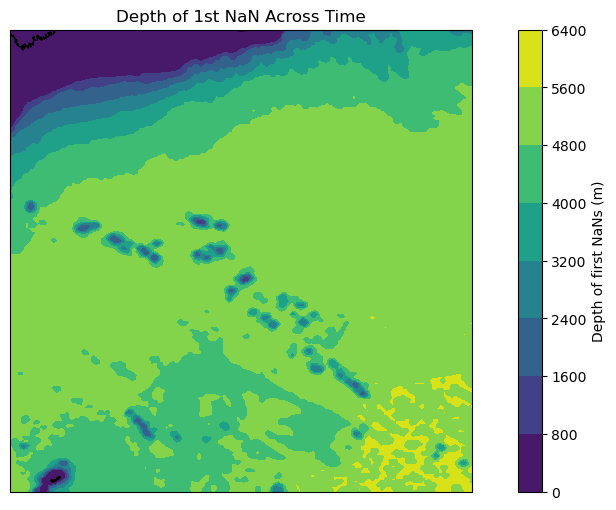

In [47]:
nan_mask = da.isnull().any(dim="time")

# Find the first depth index with NaN
depth_nan_map = xr.where(nan_mask, da["z"], np.nan).min(dim="z")


fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add coastlines
ax.coastlines()

# Ensure proper plotting with lat/lon bounds and automatic scaling
lat = depth_nan_map["lat"]
lon = depth_nan_map["lon"]

# Use contourf or imshow for better compatibility with Cartopy
pcm = ax.contourf(
    lon, lat, depth_nan_map, cmap='viridis', transform=ccrs.PlateCarree()
)

# Add a color bar
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical')
cbar.set_label("Depth of first NaNs (m)")

# Add extra map features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title("Depth of 1st NaN Across Time")

plt.show()

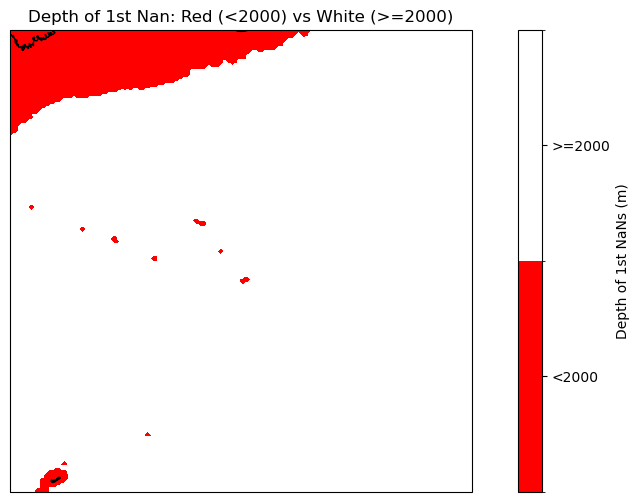

In [5]:

# Classify depth: red if depth < 2000, white if depth >= 2000.
# We create a new DataArray "classification" with values 0 for red and 1 for white.
classification = xr.where(depth_nan_map < 2000, 0, 1)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Grab lat and lon coordinates
lat = depth_nan_map["lat"]
lon = depth_nan_map["lon"]

# Define a discrete colormap: 0 -> red, 1 -> white.
cmap = mcolors.ListedColormap(["red", "white"])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Use contourf to plot the classification.
pcm = ax.contourf(
    lon, lat, classification,
    levels=bounds, cmap=cmap, norm=norm,
    transform=ccrs.PlateCarree()
)

# Add a color bar with custom tick labels.
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', ticks=[0, 1])
cbar.ax.set_yticklabels(["<2000", ">=2000"])
cbar.set_label("Depth of 1st NaNs (m)")

ax.set_title("Depth of 1st Nan: Red (<2000) vs White (>=2000)")
plt.show()


In [43]:
# Find the coordinates where the depth of the first NaN is closest to 1500m
target_depth = 500
depth_diff = np.abs(depth_nan_map - target_depth)
min_diff_idx = np.unravel_index(np.nanargmin(depth_diff), depth_diff.shape)
lat_500 = depth_nan_map.lat[min_diff_idx[0]].item()
lon_500 = depth_nan_map.lon[min_diff_idx[1]].item()

# Find the coordinates where the depth of the first NaN is closest to 1500m
target_depth = 1000
depth_diff = np.abs(depth_nan_map - target_depth)
min_diff_idx = np.unravel_index(np.nanargmin(depth_diff), depth_diff.shape)
lat_1000 = depth_nan_map.lat[min_diff_idx[0]].item()
lon_1000 = depth_nan_map.lon[min_diff_idx[1]].item()

# Find the coordinates where the depth of the first NaN is closest to 1500m
target_depth = 1250
depth_diff = np.abs(depth_nan_map - target_depth)
min_diff_idx = np.unravel_index(np.nanargmin(depth_diff), depth_diff.shape)
lat_1250 = depth_nan_map.lat[min_diff_idx[0]].item()
lon_1250 = depth_nan_map.lon[min_diff_idx[1]].item()

# Find the coordinates where the depth of the first NaN is closest to 1500m
target_depth = 1500
depth_diff = np.abs(depth_nan_map - target_depth)
min_diff_idx = np.unravel_index(np.nanargmin(depth_diff), depth_diff.shape)
lat_1500 = depth_nan_map.lat[min_diff_idx[0]].item()
lon_1500 = depth_nan_map.lon[min_diff_idx[1]].item()

print(f"The coordinates closest to a depth of 1500m with NaN are: {(lat_1500, lon_1500)}")

# Find the coordinates where the depth of the first NaN is closest to 1500m
target_depth = 2000
depth_diff = np.abs(depth_nan_map - target_depth)
min_diff_idx = np.unravel_index(np.nanargmin(depth_diff), depth_diff.shape)
lat_2000 = depth_nan_map.lat[min_diff_idx[0]].item()
lon_2000 = depth_nan_map.lon[min_diff_idx[1]].item()

print(f"The coordinates closest to a depth of 1500m with NaN are: {(lat_2000, lon_2000)}")



The coordinates closest to a depth of 1500m with NaN are: (41.75000000000023, -65.55000000000076)
The coordinates closest to a depth of 1500m with NaN are: (37.55000000000017, -59.95000000000108)


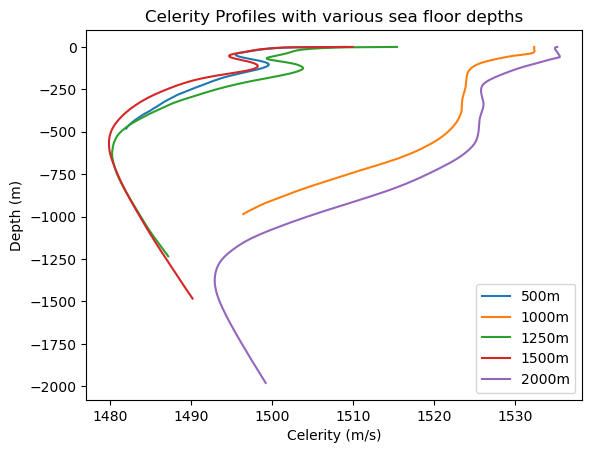

In [46]:
# Plot the celerity profile at the closest coordinates
ssp_500 = da.sel(lat=lat_500, lon=lon_500, method='nearest')[0, :]
ssp_1000 = da.sel(lat=lat_1000, lon=lon_1000, method='nearest')[0, :]
ssp_1250 = da.sel(lat=lat_1250, lon=lon_1250, method='nearest')[0, :]
ssp_1500 = da.sel(lat=lat_1500, lon=lon_1500, method='nearest')[0, :]
ssp_2000 = da.sel(lat=lat_2000, lon=lon_2000, method='nearest')[0, :]

plt.plot(ssp_500, -da.z, label='500m')
plt.plot(ssp_1000, -da.z, label='1000m')
plt.plot(ssp_1250, -da.z, label='1250m')
plt.plot(ssp_1500, -da.z, label='1500m')
plt.plot(ssp_2000, -da.z, label='2000m')
plt.ylabel("Depth (m)")
plt.xlabel("Celerity (m/s)")
plt.title("Celerity Profiles with various sea floor depths")
plt.legend()
plt.show()

In [11]:
data_path = "/Odyssey/public/enatl60/celerity/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"
da = xr.open_dataarray(data_path)
da


<xarray.DataArray 'celerity' (time: 365, z: 107, lat: 240, lon: 240)>
[2249568000 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [12]:
nan_mask = da.isnull().any(dim="time")

# Find the first depth index with NaN
depth_nan_map = xr.where(nan_mask, da["z"], np.nan).min(dim="z")

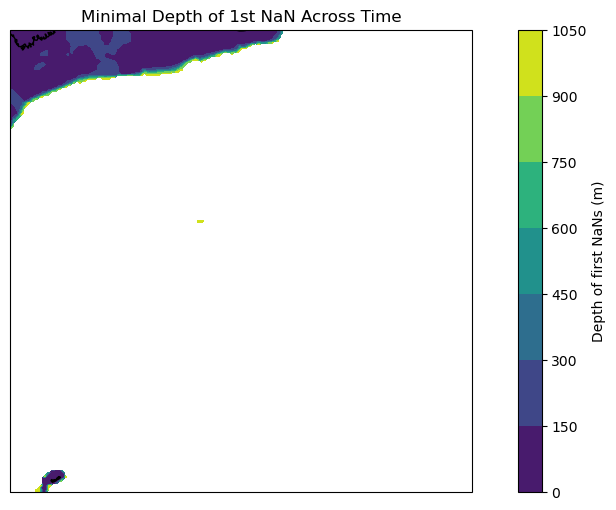

In [13]:
nan_mask = da.isnull().any(dim="time")

# Find the first depth index with NaN
depth_nan_map = xr.where(nan_mask, da["z"], np.nan).min(dim="z")

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Add coastlines
ax.coastlines()

# Ensure proper plotting with lat/lon bounds and automatic scaling
lat = depth_nan_map["lat"]
lon = depth_nan_map["lon"]

# Use contourf or imshow for better compatibility with Cartopy
pcm = ax.contourf(
    lon, lat, depth_nan_map, cmap='viridis', transform=ccrs.PlateCarree()
)

# Add a color bar
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical')
cbar.set_label("Depth of first NaNs (m)")

# Add extra map features
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_title("Minimal Depth of 1st NaN Across Time")

plt.show()

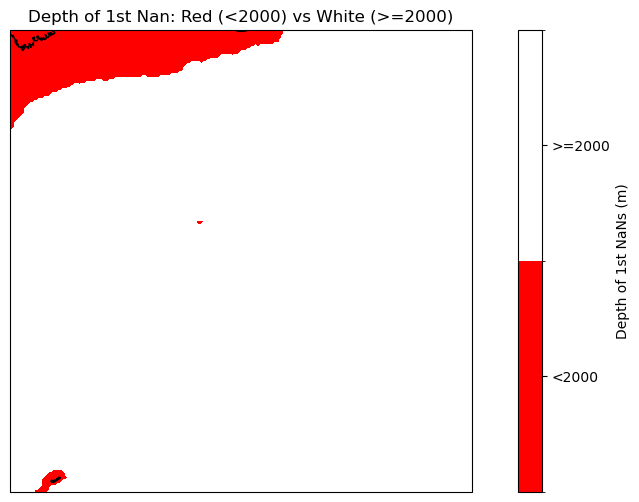

In [14]:

# Classify depth: red if depth < 2000, white if depth >= 2000.
# We create a new DataArray "classification" with values 0 for red and 1 for white.
classification = xr.where(depth_nan_map < 2000, 0, 1)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines and borders
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Grab lat and lon coordinates
lat = depth_nan_map["lat"]
lon = depth_nan_map["lon"]

# Define a discrete colormap: 0 -> red, 1 -> white.
cmap = mcolors.ListedColormap(["red", "white"])
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Use contourf to plot the classification.
pcm = ax.contourf(
    lon, lat, classification,
    levels=bounds, cmap=cmap, norm=norm,
    transform=ccrs.PlateCarree()
)

# Add a color bar with custom tick labels.
cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', ticks=[0, 1])
cbar.ax.set_yticklabels(["<2000", ">=2000"])
cbar.set_label("Depth of 1st NaNs (m)")

ax.set_title("Depth of 1st Nan: Red (<2000) vs White (>=2000)")
plt.show()


In [16]:
da.coords

Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.0 32.05 32.1 32.15 32.2 ... 43.8 43.85 43.9 43.95
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

1002.3727184870964

In [20]:
da.sel(lat=43, lon=-65.5, method='nearest')[0, :]

<xarray.DataArray 'celerity' (z: 107)>
array([1505.178212, 1501.247651, 1497.947515, 1496.663314, 1496.156282,
       1495.885553, 1495.692228, 1495.514461, 1495.304121, 1495.038784,
       1494.747634, 1494.476427, 1494.235718, 1494.003462, 1493.739395,
       1493.393719, 1492.917913, 1492.299774, 1491.58848 , 1490.871074,
       1490.230815, 1489.716426, 1489.263441, 1488.779319, 1488.43657 ,
       1488.311174, 1488.247252, 1488.149427, 1488.005577, 1487.902859,
       1488.015123, 1488.506223, 1488.794037,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan])
Coordinates:
    lon      float64 -65.5
    lat      float64 43.0
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
    time     datetime64[ns] 2009-07-01T12:00:00

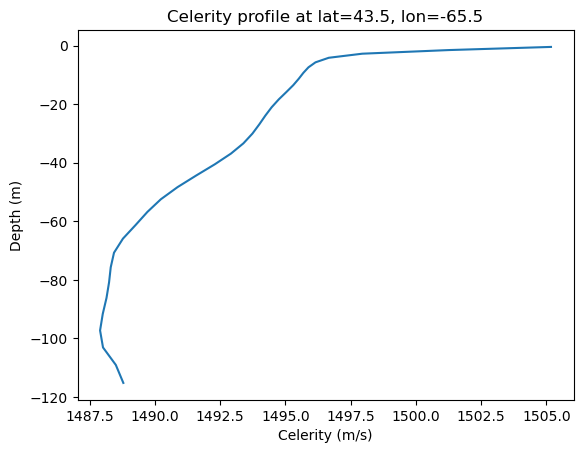

In [21]:
#plt.plot(da[0,:,0,0], -da.z)
plt.plot(da.sel(lat=43, lon=-65.5, method='nearest')[0, :], -da.z)
plt.ylabel("Depth (m)")
plt.xlabel("Celerity (m/s)")
plt.title("Celerity profile at lat=43.5, lon=-65.5")
plt.show()